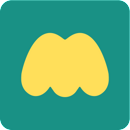

# Modak - data engineer challenge

## 1. Libs

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data loading

In [25]:
allowance_backend_table = pd.read_csv('data/allowance_backend_table.csv')
allowance_backend_table.head()

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
0,30f4e25e-3e37-462e-8c3c-42f24f54350f,1724838709,monthly,fifteenth_day,2024-10-15T08:00:41.445627563Z,15,enabled
1,6da398ad-079d-49b9-8668-6d7ce4d22683,1724659829,monthly,fifteenth_day,1724659829,15,enabled
2,2d30fe2d-6c32-4b8a-a19b-906184f64f62,1731309159,monthly,fifteenth_day,1731309159,15,enabled
3,c30180f3-b35c-470c-b25a-f12ec4ce3340,1725414982,monthly,first_day,2024-10-01T08:00:37.516552581Z,1,enabled
4,9f5768db-e953-4057-9fa5-264c46293fbd,1726267511,biweekly,friday,2024-10-02T02:33:10.97923183Z,11,disabled


In [38]:
payment_schedule_backend_table = pd.read_csv('data/payment_schedule_backend_table.csv')
payment_schedule_backend_table.head()

,user_id,payment_date
0,061d8039-b332-40ca-b906-3514b06411c2,22
1,0ca92d01-feed-42e5-b90c-299b615f9d3f,22
2,160bcd2d-3ab0-4a60-9bfa-ccfcc1ee17e4,22
3,1649fee7-c424-4fb7-ac84-db36e15e042a,22
4,1d647703-874d-4744-b4de-6a5212518aa8,22


In [4]:
with open('data/allowance_events.json') as f:
    allowance_events_json = json.load(f)
allowance_events = pd.json_normalize(allowance_events_json)
allowance_events.head()

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
0,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-21 1:39:34,allowance.created,weekly,sunday,10
1,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
2,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
3,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 6:32:28,allowance.created,biweekly,friday,10
4,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 6:32:37,allowance.edited,weekly,friday,10


## 3. Data transformation

In [21]:
def parse_unix_or_date(val):
    """
    Convert a mixed-format value from the updated_at column to a datetime.
    If the value is numeric (or a numeric string), treat it as a Unix timestamp.
    Otherwise, assume it's an ISO-formatted datetime string.
    """
    # Check if the value is a string and represents digits only.
    if isinstance(val, str) and val.isdigit():
        return pd.to_datetime(val, unit='s')
    # If the value is already numeric, convert from Unix timestamp.
    elif isinstance(val, (int, float)):
        return pd.to_datetime(val, unit='s')
    else:
        # Otherwise, attempt to parse as a datetime string.
        return pd.to_datetime(val, errors='coerce', format='ISO8601')

#### Allowance Backend Table (`allowance_backend_table`)  
* Purpose: Stores the current allowance settings for each user, reflecting their 
most recent allowance configuration.  
* Operation:  
  * When a user creates or edits an allowance, this table should be updated 
to reflect the latest `frequency`, `day`, and `next_payment_day`.  
  * The `next_payment_day` field should accurately represent the upcoming 
payment date based on the user's allowance settings.  
  * The allowances get created with the `status` column `enabled`, but the 
users can turn them to `disabled`. Make sure you only use the enabled 
allowances.  
* Potential Issues:  
  * Discrepancies during the affected period may have resulted in incorrect 
`next_payment_day` values in this table.  

In [31]:
allowance_backend_table['creation_date'] = allowance_backend_table['creation_date'].apply(parse_unix_or_date)
allowance_backend_table['updated_at'] = allowance_backend_table['updated_at'].apply(parse_unix_or_date)

allowance_backend_table = allowance_backend_table.sort_values(['creation_date'])

In [35]:
allowance_backend_table.head()

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
1973,7cbedb99-a6d4-45a1-880d-0e661d4b9f75,2024-07-25 18:18:14,biweekly,saturday,2024-11-21 15:25:27.689063932+00:00,30,enabled
1974,c5a7c5f7-6c1e-4ea0-919a-f7efdf4e7cc9,2024-07-25 18:19:09,weekly,friday,2024-08-11 15:29:58.864236548+00:00,16,disabled
1326,c440479e-8cf2-402e-8da9-9c682ea3df39,2024-07-25 18:25:46,biweekly,thursday,2024-11-28 08:00:33.049761141+00:00,12,enabled
798,27602664-335c-4beb-9dd7-7c6942385b64,2024-07-25 18:26:29,weekly,friday,2024-07-26 17:22:16.495657547+00:00,26,disabled
800,d278205f-4175-4dbb-a398-5661a0a9c9f3,2024-07-25 18:26:41,weekly,sunday,2024-12-01 08:01:44.700817530+00:00,8,enabled


In [33]:
allowance_backend_table.dtypes

uuid                        object
creation_date       datetime64[ns]
frequency                   object
day                         object
updated_at                  object
next_payment_day             int64
status                      object
dtype: object

In [9]:
allowance_backend_table

,uuid,creation_date,frequency,day,updated_at,next_payment_day,status
0,30f4e25e-3e37-462e-8c3c-42f24f54350f,2024-08-28 09:51:49,monthly,fifteenth_day,2024-10-15 08:00:41.445627563+00:00,15,enabled
1,6da398ad-079d-49b9-8668-6d7ce4d22683,2024-08-26 08:10:29,monthly,fifteenth_day,2024-08-26 08:10:29,15,enabled
2,2d30fe2d-6c32-4b8a-a19b-906184f64f62,2024-11-11 07:12:39,monthly,fifteenth_day,2024-11-11 07:12:39,15,enabled
3,c30180f3-b35c-470c-b25a-f12ec4ce3340,2024-09-04 01:56:22,monthly,first_day,2024-10-01 08:00:37.516552581+00:00,1,enabled
4,9f5768db-e953-4057-9fa5-264c46293fbd,2024-09-13 22:45:11,biweekly,friday,2024-10-02 02:33:10.979231830+00:00,11,disabled
...,...,...,...,...,...,...,...
2877,2e26d7e7-b65e-4468-8096-5bed0ef99988,2024-10-16 17:07:15,biweekly,monday,2024-11-28 08:00:30.184784321+00:00,9,enabled
2878,adec35e8-3699-45e5-b675-4a6504b296de,2024-07-30 20:15:41,weekly,friday,2024-08-16 00:48:04.406999984+00:00,16,disabled
2879,e8505cf5-856d-4518-9cec-ffe4b72d9a45,2024-07-30 20:15:55,weekly,friday,2024-08-16 00:48:10.788978083+00:00,16,disabled
2880,e8f85eea-1974-4000-bde0-2ea7ade70f67,2024-10-22 22:39:27,biweekly,friday,2024-10-22 22:39:27,1,enabled


#### Payment Schedule Backend Table (`payment_schedule_backend_table`) 
* Purpose: Manages the scheduling of payments to users based on their 
allowance settings.  
* Operation:  
  * Each user should only have one active record in this table at any time. 
  * When a payment is made:  
    * The current record for the user is deleted.  
    * A new record is created with the upcoming payment_date.  
  * The `payment_date` should align with the `next_payment_day` from the 
`allowance_backend_table`.  
  * Users who disable the allowance should not have any active record.  
* Potential Issues: 
  * Errors during the affected period may have resulted in users having  
multiple records or incorrect `payment_date` values in this table.

In [10]:
payment_schedule_backend_table.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_date,2139.0,11.257129,8.212922,1.0,6.0,9.0,15.0,31.0


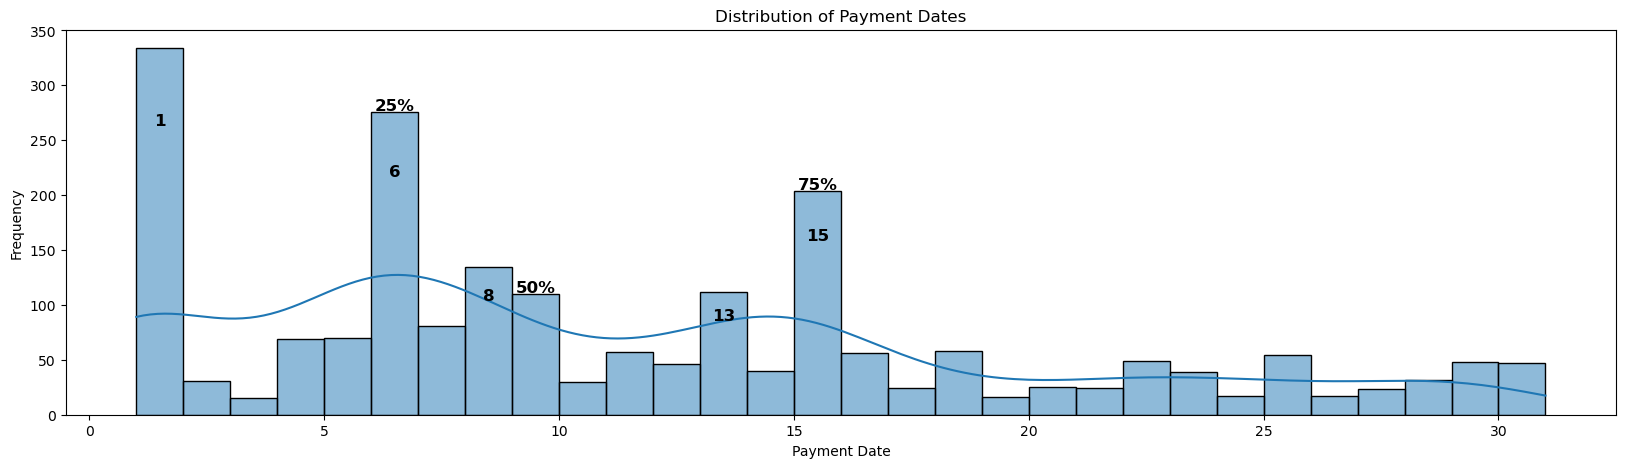

In [46]:
top_n = 5
main_observations = list(
    (
        payment_schedule_backend_table["payment_date"]
        .value_counts()
        .nlargest(top_n)
        .index.sort_values()
    )
)

# Plot distribution
plt.figure(figsize=(20, 5))
ax = sns.histplot(payment_schedule_backend_table["payment_date"], kde=True, bins=30)

# Add annotations inside the bins for main observation days
for date in main_observations:
    height = ax.patches[date - 1].get_height()  # Get bin height for annotation
    plt.text(date + 0.5, 
             height * 0.8, 
             str(date), 
             ha="center",
             va="center", 
             fontsize=12, 
             color="black", 
             fontweight="bold")
    
# Calculate quantiles
q25, q50, q75 = payment_schedule_backend_table["payment_date"].quantile([0.25, 0.5, 0.75])

for quantile, label in zip([q25, q50, q75], ["25%", "50%", "75%"]):
    for patch in ax.patches:
        if patch.get_x() <= quantile < patch.get_x() + patch.get_width():
            height = patch.get_height()
            plt.text(quantile + 0.5, 
                     height + 1,  # Slightly above the highest bar
                     label, 
                     ha="center", 
                     fontsize=12, 
                     color="black", 
                     fontweight="bold")
            
plt.xlabel("Payment Date")
plt.ylabel("Frequency")
plt.title("Distribution of Payment Dates")
plt.show()

#### `allowance_events` (JSON)  
This dataset captures the creation and updates of user allowances during the affected 
period.  
* Fields:  
  * `event.name`: The type of event, either allowance.created or  
allowance.edited.  
  * `event.timestamp`: Timestamp of the event.  
  * `user.id`: Unique identifier for the user.  
  * `allowance.amount`: Allowance amount.  
  * `allowance.scheduled.frequency`: Frequency of the allowance: 
`daily`, `weekly`, `biweekly`, or `monthly`.  
  * `allowance.scheduled.day`:  
    * `"daily"` for daily frequency.  
    * Day of the week for weekly/biweekly schedules.  
    * `"1st"` or `"15th"` for monthly schedules.

In [47]:
allowance_events['event.timestamp'] = allowance_events['event.timestamp'].apply(parse_unix_or_date)

In [48]:
allowance_events

,user.id,event.timestamp,event.name,allowance.scheduled.frequency,allowance.scheduled.day,allowance.amount
0,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-21 01:39:34,allowance.created,weekly,sunday,10
1,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
2,03c5ffe8-6cd2-434b-a1b2-c4006860d94c,2024-09-22 19:38:22,allowance.edited,weekly,sunday,10
3,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 06:32:28,allowance.created,biweekly,friday,10
4,05384674-4af8-4f70-8d8f-90e19b0db971,2024-10-06 06:32:37,allowance.edited,weekly,friday,10
...,...,...,...,...,...,...
6203,a0cd326b-bca3-454b-9ca1-127fe82e4eba,2024-11-08 06:59:25,allowance.edited,biweekly,thursday,5
6204,a0cd326b-bca3-454b-9ca1-127fe82e4eba,2024-11-08 07:00:05,allowance.edited,daily,daily,5
6205,a0cd326b-bca3-454b-9ca1-127fe82e4eba,2024-11-08 07:00:05,allowance.edited,daily,daily,5
6206,a0cd326b-bca3-454b-9ca1-127fe82e4eba,2024-11-08 07:01:13,allowance.edited,biweekly,saturday,5
